In [1]:
%matplotlib inline

import numpy as np
from dolfin import *
from mshr import *

import matplotlib.pyplot as plt

# Do not reorder degrees of freedom (dofs)
parameters['reorder_dofs_serial'] = False
# Extrapolate values to produce smoother representations
parameters['allow_extrapolation'] = True


# Solve the Poisson equation

### Step 1: Define the Domain

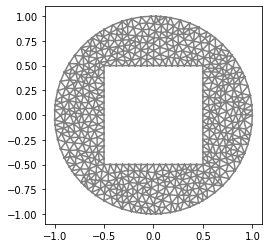

In [2]:
domain = Circle(Point(.0,.0), 1) - Rectangle(Point(-0.5,-0.5), Point(0.5,0.5))
domain_mesh = generate_mesh(domain, 20)
plot(domain_mesh)

### Step 2: Define the Function Space

In [3]:
# The basis functions are Lagrange polynomials of order 1 (i.e. linear functions)
function_space = FunctionSpace(domain_mesh, 'Lagrange', 1)

u = TrialFunction(function_space)
v = TestFunction(function_space)

### Step 3: Define the Boundary Conditions

In [4]:
def outer_boundary(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and near(np.sqrt(x**2 + y**2), 1, 5e-2)

def top_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0.5)
def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], -0.5)
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], -0.5)
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0.5)

outer_bc = DirichletBC(function_space, Constant(0), outer_boundary)
top_bc = DirichletBC(function_space, Constant(1), top_boundary)
bottom_bc = DirichletBC(function_space, Constant(-1), bottom_boundary)
left_bc = DirichletBC(function_space, Constant(2), left_boundary)
right_bc = DirichletBC(function_space, Constant(-1), right_boundary)
boundaries = [outer_bc, top_bc, bottom_bc, left_bc, right_bc]


### Step 4: Define the Equation

In [5]:
left_integrand = inner(nabla_grad(u), nabla_grad(v)) * dx
f =  Expression("x[0]*x[0]/2 + x[1]*x[1]", degree=1)
right_integrand = f*v*dx

### Step 5: Assemble and Solve the Problem

#### Method 1: Explicit

In [6]:
#set up linear algebra problem

# Assemble the matrix A 
A = assemble(left_integrand)
# Assemble the vector b
b = assemble(right_integrand)
# Apply all boundary conditions 
[bc.apply(A,b) for bc in boundaries]
# create a placeholder for solution
solution = Function(function_space) 
# compute the solution
solve(A, solution.vector(), b)

1

#### Method 2: Quick

In [7]:
solution = Function(function_space)
solve(left_integrand == right_integrand, solution, boundaries)

### Step 6: Visualize the Results

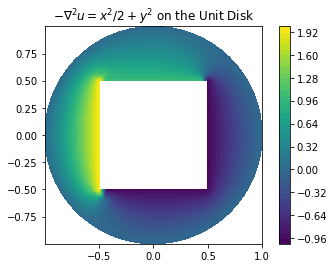

In [8]:
# Default visualization with the addition of a colorbar
p = plot(solution)
plt.title(r'$-∇ ^2 u = x^2/2+y^2$ on the Unit Disk')
plt.colorbar(p)
plt.show()

#### Visualize surface using matplotlib

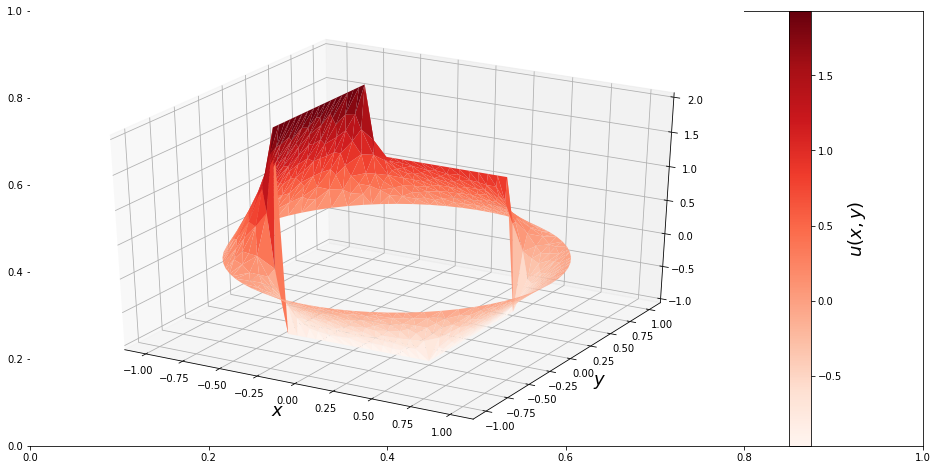

In [9]:
import matplotlib as mpl

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

def mesh_triangulation(mesh):
    """
    Convert a FEniCS mesh into a matplotlib Triangulation
    """
    coordinates = mesh.coordinates()
    triangles = mesh.cells()
    return mpl.tri.Triangulation(coordinates[:, 0], coordinates[:, 1], triangles)

triangulation = mesh_triangulation(domain_mesh)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
c = ax.plot_trisurf(triangulation, np.array(solution.vector()),cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax)
cb.set_label(r"$u(x, y)$", fontsize=18)